# Displaying data

In [635]:
%matplotlib inline

# Import dependencies
import h5py
import numpy as np
from matplotlib import pyplot as plt
import fastmri
from fastmri.data import transforms as T

In [636]:
# Define paths to image
original_image_path = "/media/drazen/HDD/PC/Faks/Diplomski/Prva/OSIRV/Projekt/datasets/multicoil_val/file_brain_AXT2_210_6001879.h5"
image_base_dir = "."
image_name = "file_brain_AXT2_210_6001879.h5"

In [637]:
# Define which slice we look for easier comparison
mri_slice = 9

## Original image

We'll import fully sampled image, display it, generate some noise on it and run it through our models.

In [638]:
hf = h5py.File(original_image_path)

In [639]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXT2', 'max': 0.0006411402391674308, 'norm': 0.16125332777179052, 'patient_id': '29793fc6de6dd9dd485719bd82adfc9d374d9219746656ff0204e1b7e5b8c42c'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [640]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 20, 768, 396)


In [641]:
slice_kspace = volume_kspace[10] # Choosing the 15-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [642]:
def show_coils(data, slice_nums, cmap='gray'):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

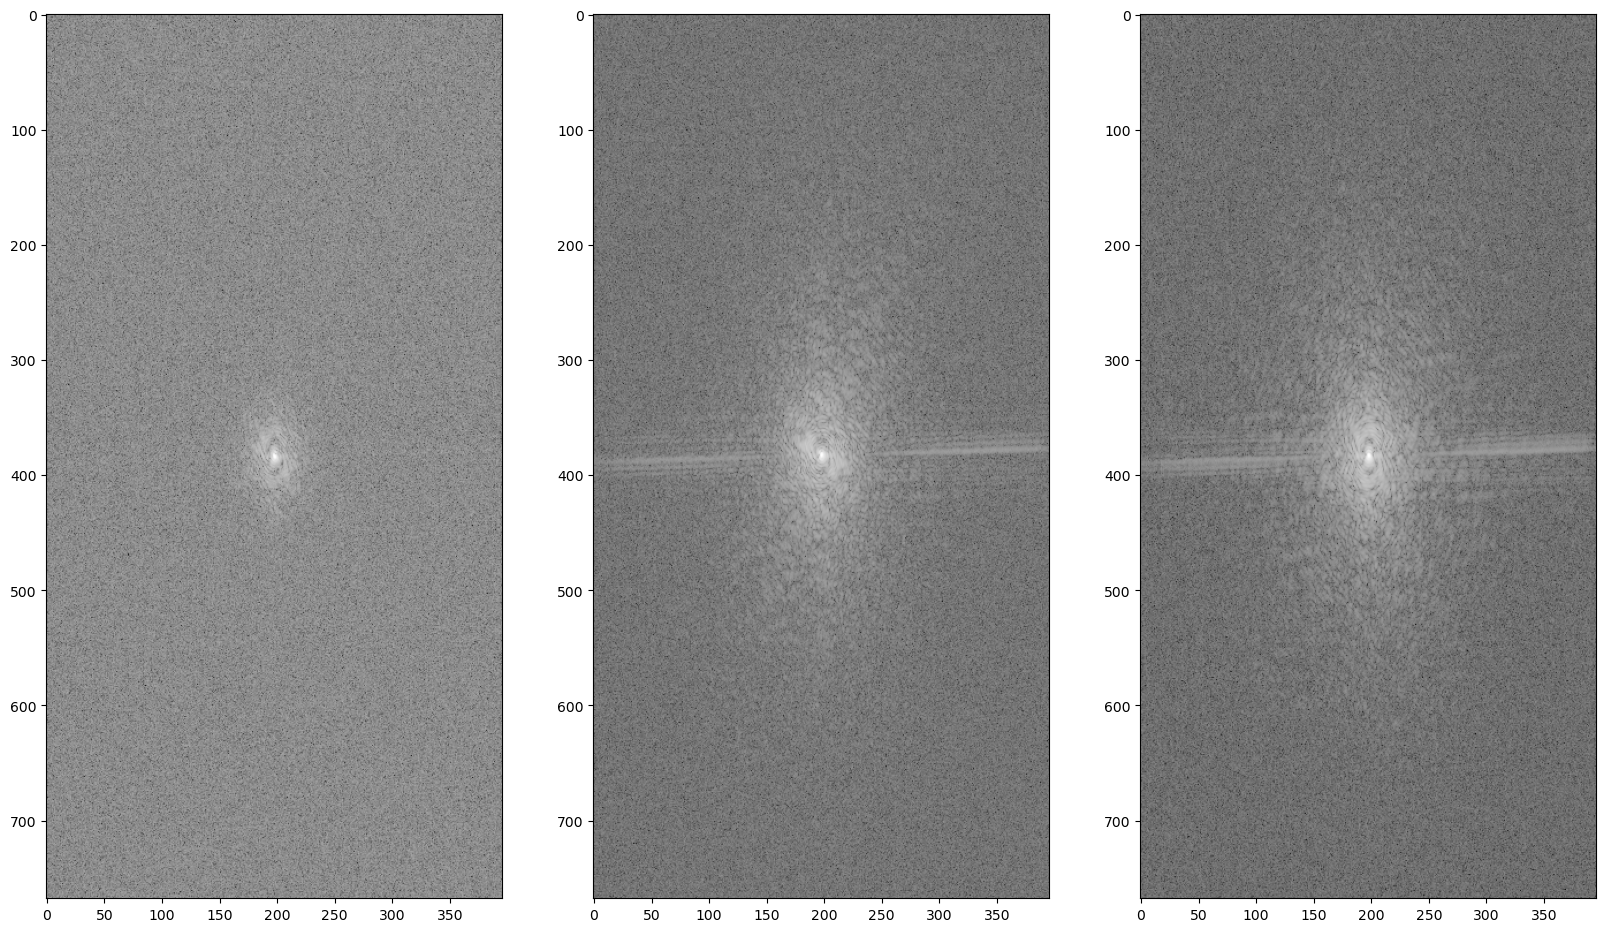

In [643]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 2, 3])  # This shows coils 0, 5 and 10

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [644]:
import fastmri
from fastmri.data import transforms as T

In [645]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

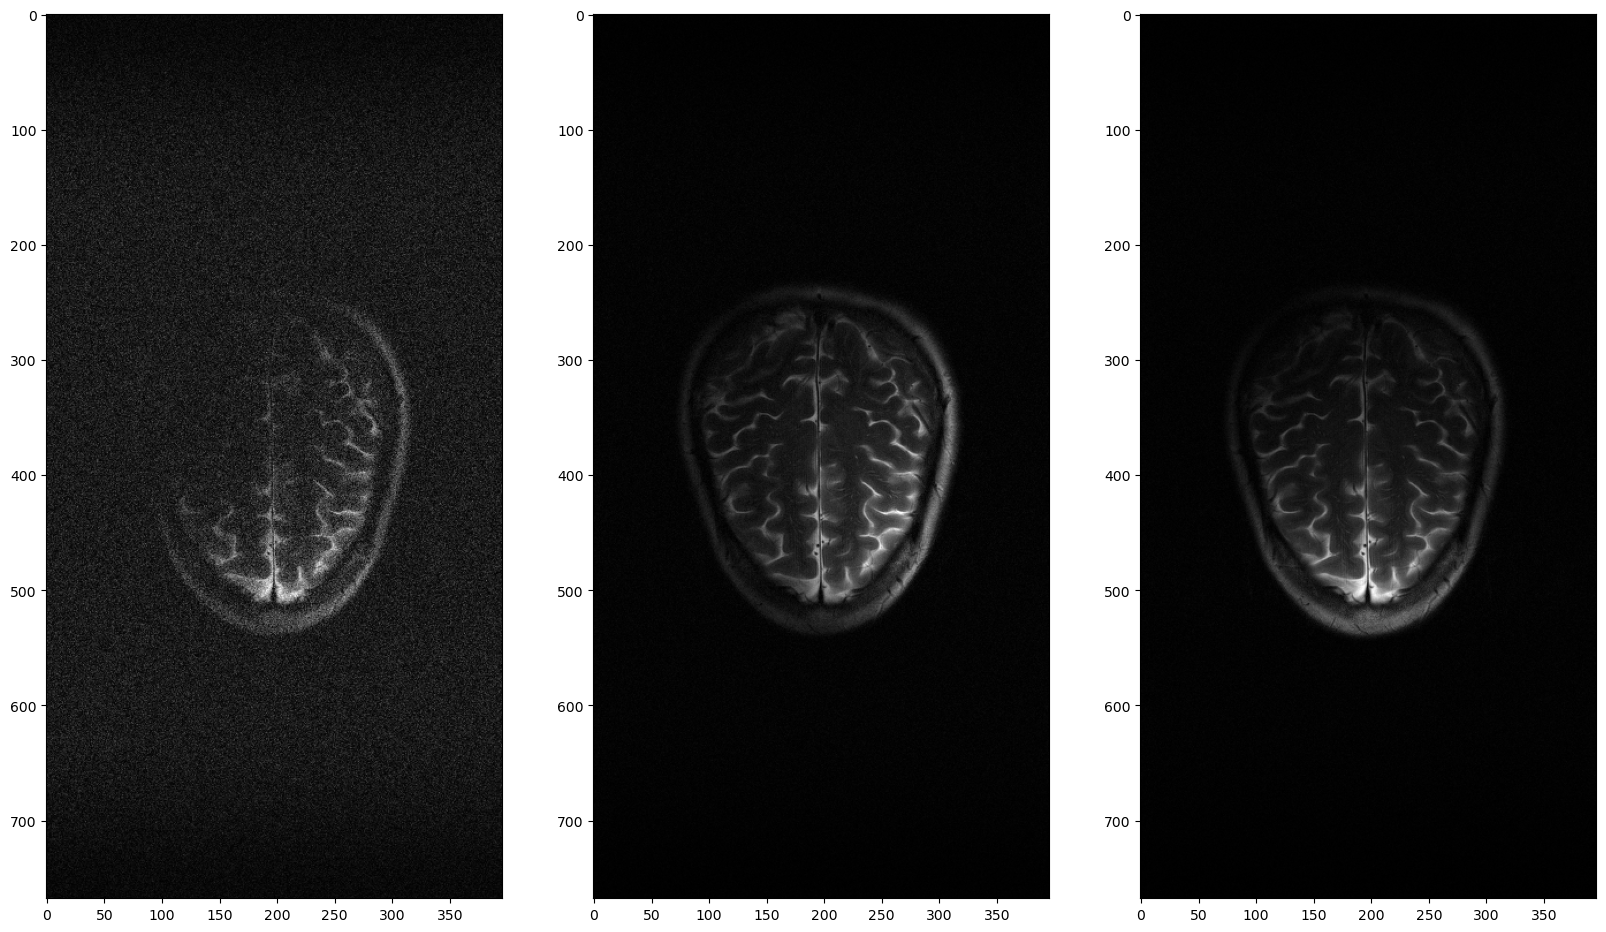

In [646]:
plt.rcParams['figure.figsize'] = [20, 16] # enlarge inline plots

show_coils(slice_image_abs, [0, 2, 3], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [647]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

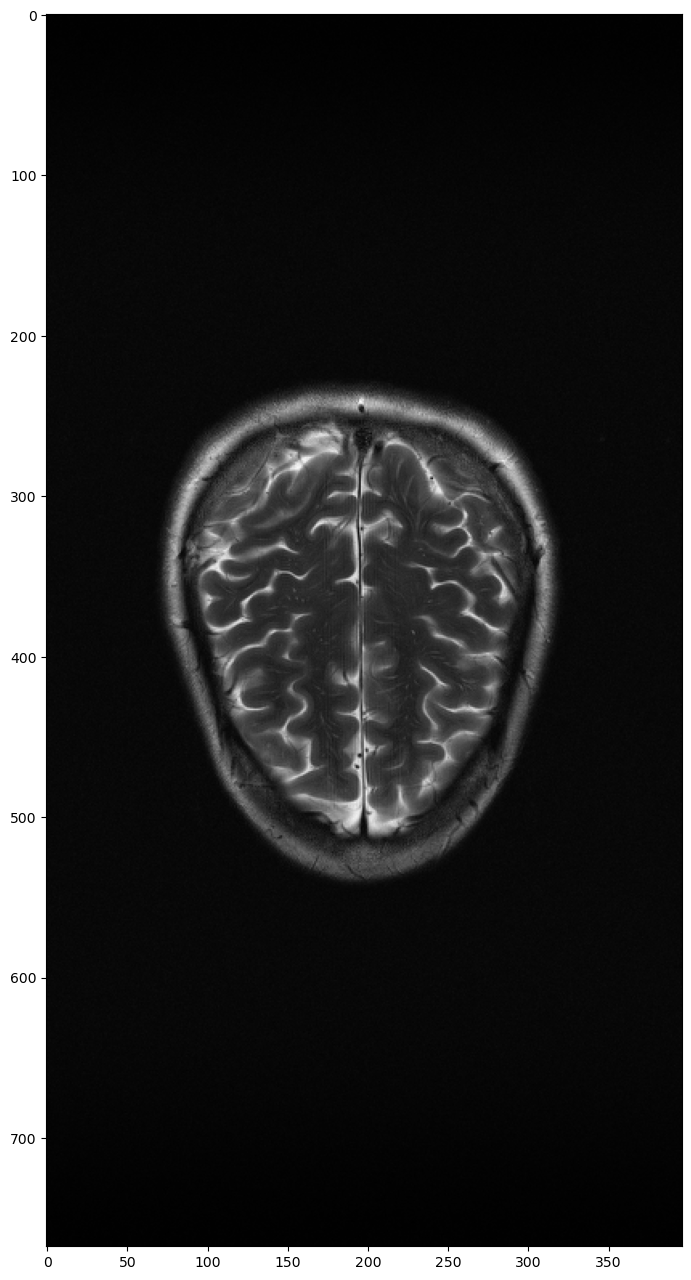

In [648]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [649]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [650]:
slice_kspace.shape

(20, 768, 396)

In [651]:
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [652]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

In [653]:
print(sampled_image_rss.shape)

torch.Size([768, 396])


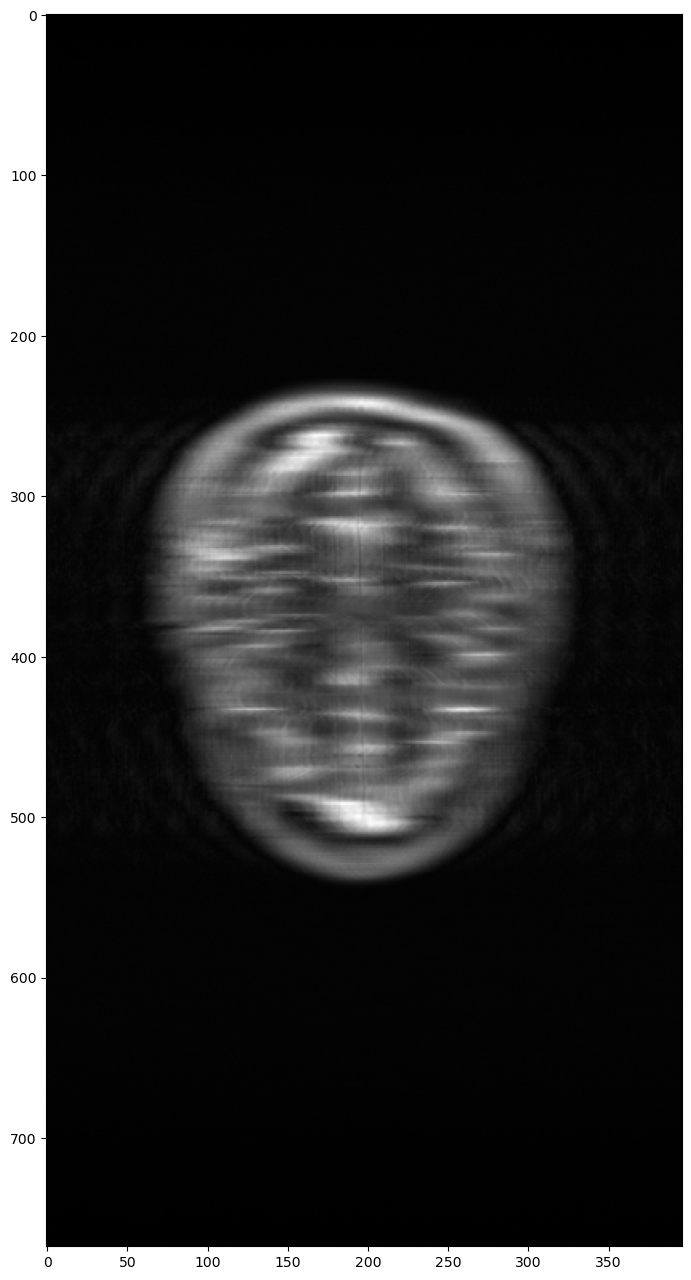

In [654]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')

Let's subsample whole volume and save it as h5 so it can be run through models.

In [655]:
kspace_data = hf['kspace']
ismrmrd_header = hf['ismrmrd_header'][()]
subsampled_data = hf['kspace']
subsampled_data = np.empty_like(kspace_data)

def np_round(array):
    return np.around(array).astype(np.int64)

mask_func = RandomMaskFunc(center_fractions=[0.08], accelerations=[4])

print('kspace_data shape:', kspace_data.shape)
print('subsampled_data shape:', subsampled_data.shape)

for i in range(kspace_data.shape[0]):
    kspace_tensor = transforms.to_tensor(kspace_data[i])
    print(kspace_tensor.shape)
    masked_tensor, mask, _ = T.apply_mask(kspace_tensor, mask_func)
    masked_array = T.tensor_to_complex_np(masked_tensor)
    subsampled_data[i] = masked_array

# print(subsampled_data)
with h5py.File("subsampled/" + image_name, 'w') as hf:
    hf.create_dataset('kspace', data=subsampled_data)
    hf.create_dataset('ismrmrd_header', data=ismrmrd_header)

kspace_data shape: (16, 20, 768, 396)
subsampled_data shape: (16, 20, 768, 396)
torch.Size([20, 768, 396, 2])
torch.Size([20, 768, 396, 2])
torch.Size([20, 768, 396, 2])
torch.Size([20, 768, 396, 2])
torch.Size([20, 768, 396, 2])
torch.Size([20, 768, 396, 2])
torch.Size([20, 768, 396, 2])
torch.Size([20, 768, 396, 2])
torch.Size([20, 768, 396, 2])
torch.Size([20, 768, 396, 2])
torch.Size([20, 768, 396, 2])
torch.Size([20, 768, 396, 2])
torch.Size([20, 768, 396, 2])
torch.Size([20, 768, 396, 2])
torch.Size([20, 768, 396, 2])
torch.Size([20, 768, 396, 2])


## Compressed image

In [656]:
hf = h5py.File("subsampled/" + image_name)
# hf = h5py.File("/media/drazen/Transcend/MRI/multicoil_temp/file_brain_AXFLAIR_200_6002564.h5")

print('Keys: ', list(hf.keys()))
print('Keys: ', dict(hf.attrs))

Keys:  ['ismrmrd_header', 'kspace']
Keys:  {}


Showing kspace parameters.

In [657]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 20, 768, 396)


First parameter represents number of slices.

Choosing the 10-th slice of this volume

In [658]:
slice_kspace = volume_kspace[mri_slice]

Absolute value of k-space

In [659]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

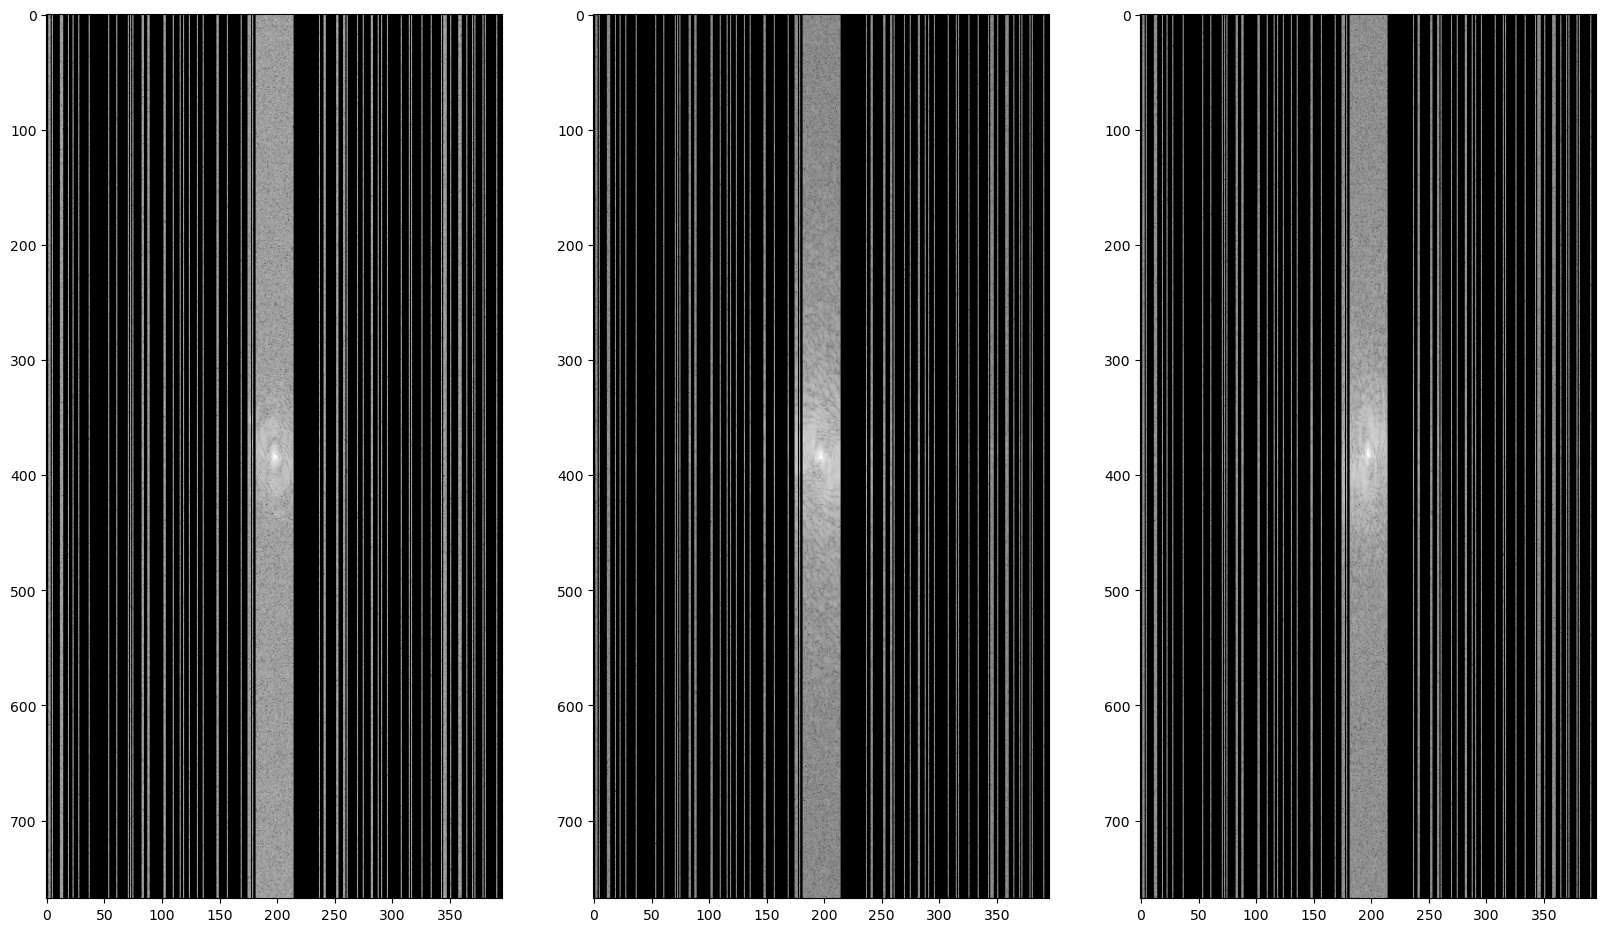

In [660]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10], cmap='gray')  # This shows coils 0, 5 and 10

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [661]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

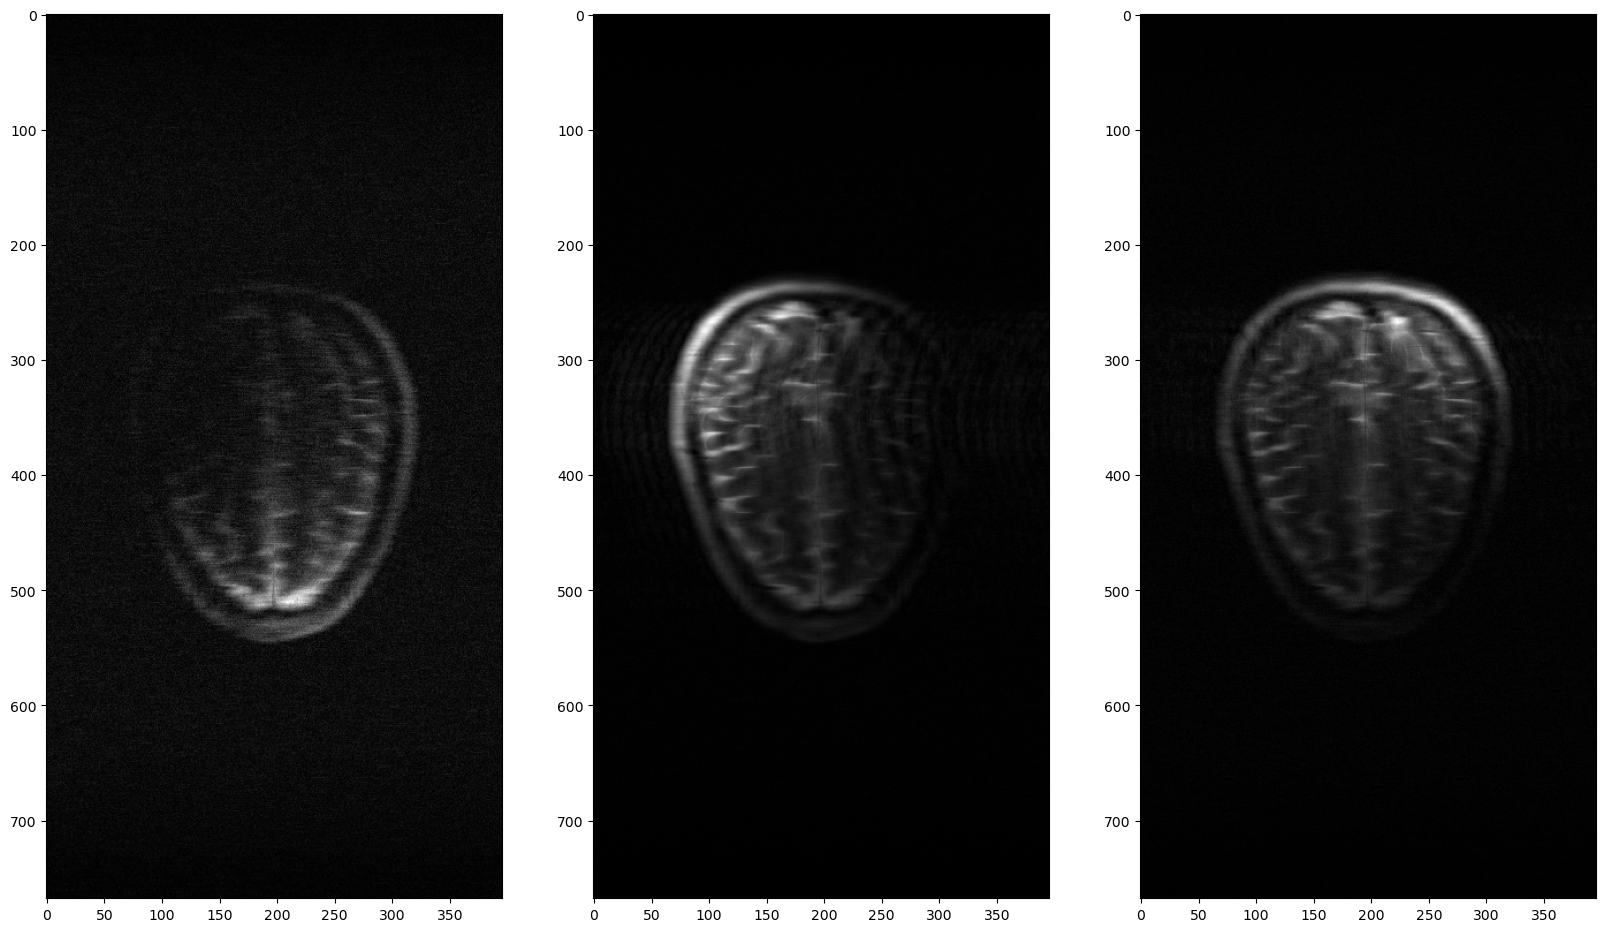

In [662]:
plt.rcParams['figure.figsize'] = [20, 16] # enlarge inline plots

show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [663]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

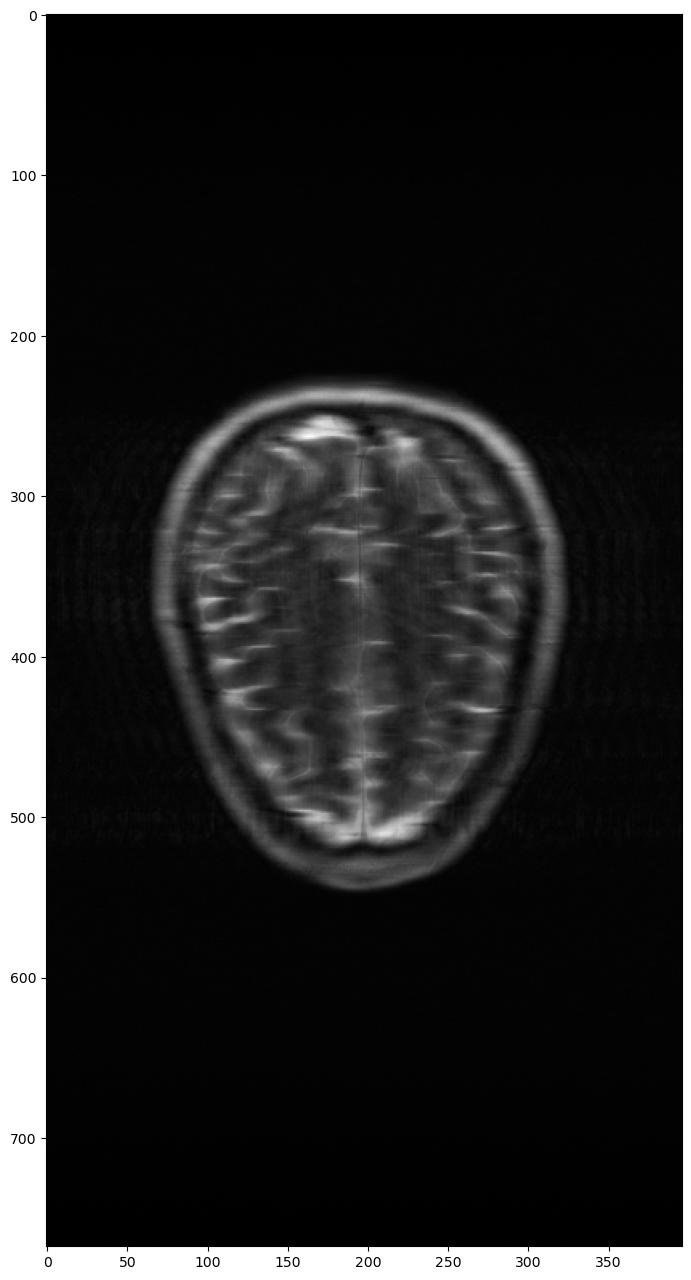

In [664]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

## Functions

In [665]:
def show_slices(data, num_slices, cmap=None):
    fig = plt.figure()
    for i in range(0, num_slices):
        plt.subplot(3, 5, i + 1)
        plt.imshow(data[i], cmap=cmap)

## Zero-Filled

In [666]:
hf = h5py.File(image_base_dir + "/outputs/zero_filled/" + image_name)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = './outputs/zero_filled/file_brain_AXT2_210_6001879.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

We don't have `kspace` key anymore, now we have to use `reconstruction` key.

`Reconstruction` volume has the following shape: (number of slices, height, width).

In [ ]:
zf_volume_reconstruction = hf['reconstruction'][()]
print(zf_volume_reconstruction.dtype)
print(zf_volume_reconstruction.shape)

In [ ]:
zf_slice_reconstruction = zf_volume_reconstruction[mri_slice] # Choosing slice
print(zf_slice_reconstruction.shape)

In [ ]:
plt.rcParams['figure.figsize'] = [25, 16] # enlarge inline plots

show_slices(zf_volume_reconstruction, 15, cmap='gray')

# fig = plt.figure()
# plt.imshow(slice_reconstruction, cmap='gray')

Let's show 10th slice.

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(zf_slice_reconstruction, cmap='gray')

## Compressed Sensing

In [ ]:
hf = h5py.File(image_base_dir + "/outputs/cs/" + image_name)

In [ ]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

We don't have `kspace` key anymore, now we have to use `reconstruction` key.

`Reconstruction` volume has the following shape: (number of slices, height, width).

In [ ]:
cs_volume_reconstruction = hf['reconstruction'][()]
print(cs_volume_reconstruction.dtype)
print(cs_volume_reconstruction.shape)

In [ ]:
cs_slice_reconstruction = cs_volume_reconstruction[mri_slice] # Choosing slice
print(cs_slice_reconstruction.shape)

In [ ]:
plt.rcParams['figure.figsize'] = [25, 16] # enlarge inline plots

show_slices(cs_volume_reconstruction, 15, cmap='gray')

# fig = plt.figure()
# plt.imshow(slice_reconstruction, cmap='gray')

Let's show 10th slice.

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(cs_slice_reconstruction, cmap='gray')

## Varnet

In [ ]:
hf = h5py.File(image_base_dir + "/outputs/varnet/reconstructions/" + image_name)

In [ ]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

We don't have `kspace` key anymore, now we have to use `reconstruction` key.

`Reconstruction` volume has the following shape: (number of slices, height, width).

In [ ]:
varnet_volume_reconstruction = hf['reconstruction'][()]
print(varnet_volume_reconstruction.dtype)
print(varnet_volume_reconstruction.shape)

In [ ]:
varnet_slice_reconstruction = varnet_volume_reconstruction[mri_slice] # Choosing slice
print(varnet_slice_reconstruction.shape)

In [ ]:
plt.rcParams['figure.figsize'] = [25, 16] # enlarge inline plots

show_slices(varnet_volume_reconstruction, 15, cmap='gray')

# fig = plt.figure()
# plt.imshow(slice_reconstruction, cmap='gray')

Let's show 10th slice.

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(varnet_slice_reconstruction, cmap='gray')

## U-Net

In [ ]:
hf = h5py.File(image_base_dir + "/outputs/unet/reconstructions/" + image_name)

In [ ]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

We don't have `kspace` key anymore, now we have to use `reconstruction` key.

`Reconstruction` volume has the following shape: (number of slices, height, width).

In [ ]:
unet_volume_reconstruction = hf['reconstruction'][()]
print(unet_volume_reconstruction.dtype)
print(unet_volume_reconstruction.shape)

In [ ]:
unet_slice_reconstruction = unet_volume_reconstruction[mri_slice] # Choosing slice
print(unet_slice_reconstruction.shape)

In [ ]:
plt.rcParams['figure.figsize'] = [25, 16] # enlarge inline plots

show_slices(unet_volume_reconstruction.reshape(16, 320, 320), 15, cmap='gray')

Let's show 10th slice.

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(unet_slice_reconstruction.reshape(320,320), cmap='gray')